In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



In [37]:
import pandas as pd
df = pd.read_csv("Unemployment_Rate_upto_11_2020.csv")  # adjust filename
df.head()
print(df.columns.tolist())
df.info()


['Region', ' Date', ' Frequency', ' Estimated Unemployment Rate (%)', ' Estimated Employed', ' Estimated Labour Participation Rate (%)', 'Region.1', 'longitude', 'latitude']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 9 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Region                                    267 non-null    object 
 1    Date                                     267 non-null    object 
 2    Frequency                                267 non-null    object 
 3    Estimated Unemployment Rate (%)          267 non-null    float64
 4    Estimated Employed                       267 non-null    int64  
 5    Estimated Labour Participation Rate (%)  267 non-null    float64
 6   Region.1                                  267 non-null    object 
 7   longitude                                 267 non-null    float64
 8   latitud

In [38]:
df.head()


,Region,Date,Frequency,Estimated Unemployment Rate (%),Estimated Employed,Estimated Labour Participation Rate (%),Region.1,longitude,latitude
0,Andhra Pradesh,31-01-2020,M,5.48,16635535,41.02,South,15.9129,79.74
1,Andhra Pradesh,29-02-2020,M,5.83,16545652,40.90,South,15.9129,79.74
2,Andhra Pradesh,31-03-2020,M,5.79,15881197,39.18,South,15.9129,79.74
3,Andhra Pradesh,30-04-2020,M,20.51,11336911,33.10,South,15.9129,79.74
4,Andhra Pradesh,31-05-2020,M,17.43,12988845,36.46,South,15.9129,79.74


In [39]:
df.columns = [c.strip().lower().replace(' ', '_').replace('(', '').replace(')', '') for c in df.columns]

# typical names: state, date, frequency, estimated_unemployment_rate_percent

df = df.rename(columns=lambda x: x.replace('%','pct'))

# parse date (some Kaggle files use 'yyyy-mm' or 'dd-mm-yyyy')

df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=False)

# choose sort column: prefer 'state' if present, else 'region'
sort_col = 'state' if 'state' in df.columns else ('region' if 'region' in df.columns else None)
if sort_col:
  df = df.sort_values([sort_col, 'date']).reset_index(drop=True)
else:
  df = df.sort_values('date').reset_index(drop=True)


C:\Users\User\AppData\Local\Temp\ipykernel_16172\1411437569.py:9: UserWarning: Parsing dates in  %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=False)


In [40]:
df[df['date'].isna()].head()



,region,date,frequency,estimated_unemployment_rate_pct,estimated_employed,estimated_labour_participation_rate_pct,region.1,longitude,latitude


In [41]:
rate_col = [c for c in df.columns if 'unemploy' in c or 'rate' in c or 'estimated' in c][0]
df[rate_col] = df[rate_col].astype(str).str.replace('%','').str.replace(',','').str.strip()
df[rate_col] = pd.to_numeric(df[rate_col], errors='coerce')
df = df.rename(columns={rate_col: 'unemp_rate'})


In [42]:
df['unemp_rate'].isna().sum(), df['unemp_rate'].describe()


(np.int64(0),
 count    267.000000
 mean      12.236929
 std       10.803283
 min        0.500000
 25%        4.845000
 50%        9.650000
 75%       16.755000
 max       75.850000
 Name: unemp_rate, dtype: float64)

In [43]:
# remove rows with any missing values and report counts

df.isnull().sum()


region                                     0
date                                       0
frequency                                  0
unemp_rate                                 0
estimated_employed                         0
estimated_labour_participation_rate_pct    0
region.1                                   0
longitude                                  0
latitude                                   0
dtype: int64

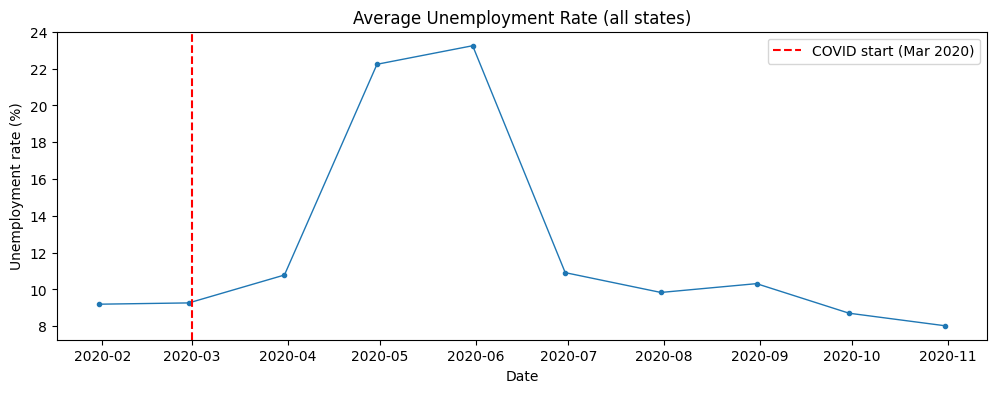

In [44]:
# use the existing dataframe `df` (df_full is not defined in this notebook)
national = df.groupby('date')['unemp_rate'].mean().reset_index(name='national_unemp')
plt.figure(figsize=(12,4))
plt.plot(national['date'], national['national_unemp'], marker='.', linewidth=1)
plt.title('Average Unemployment Rate (all states)')
plt.xlabel('Date'); plt.ylabel('Unemployment rate (%)')
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--', label='COVID start (Mar 2020)')
plt.legend()
plt.show()


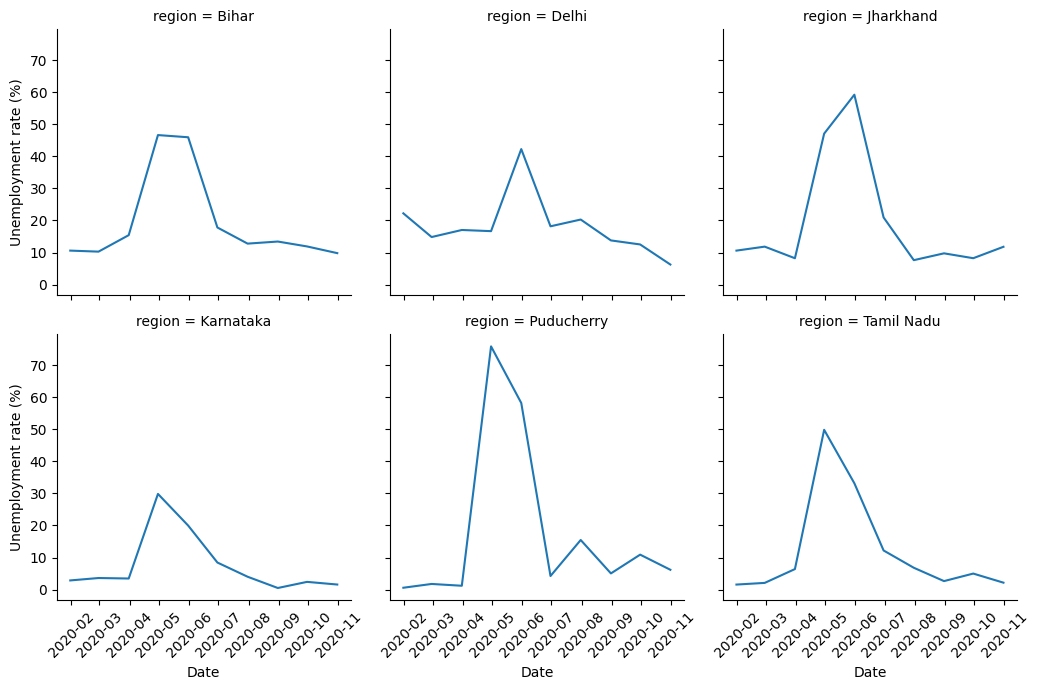

In [45]:
# use existing `df` and the correct column name 'region' (no `df_full` or 'state' column in this notebook)
top_regions = df.groupby('region')['unemp_rate'].std().sort_values(ascending=False).head(6).index
g = sns.FacetGrid(df[df['region'].isin(top_regions)], col='region', col_wrap=3, height=3.5)
g.map_dataframe(sns.lineplot, x='date', y='unemp_rate')
g.set_axis_labels("Date", "Unemployment rate (%)")
for ax in g.axes.flatten():
	for label in ax.get_xticklabels():
		label.set_rotation(45)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Heatmap of Unemployment rate by State over time')

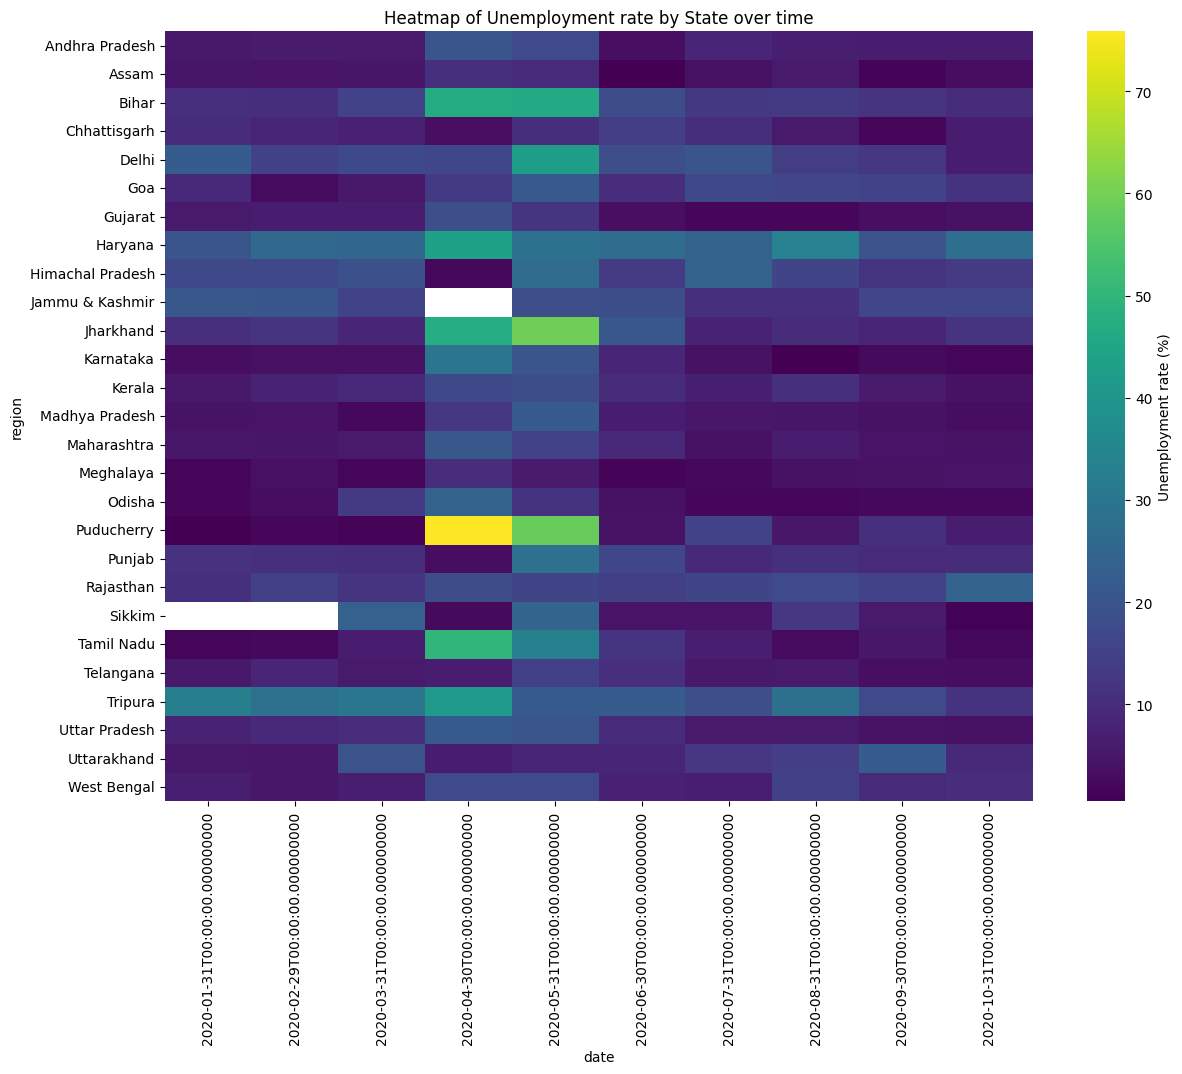

In [46]:
pivot = df.pivot_table(index='region', columns='date', values='unemp_rate')
plt.figure(figsize=(14,10))
sns.heatmap(pivot, cmap='viridis', cbar_kws={'label':'Unemployment rate (%)'})
plt.title('Heatmap of Unemployment rate by State over time')


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


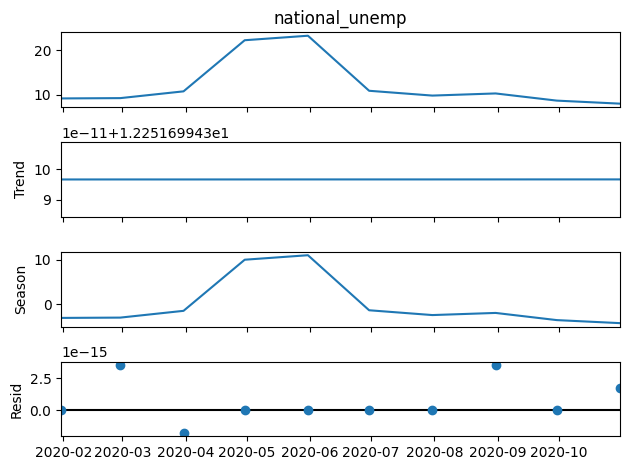

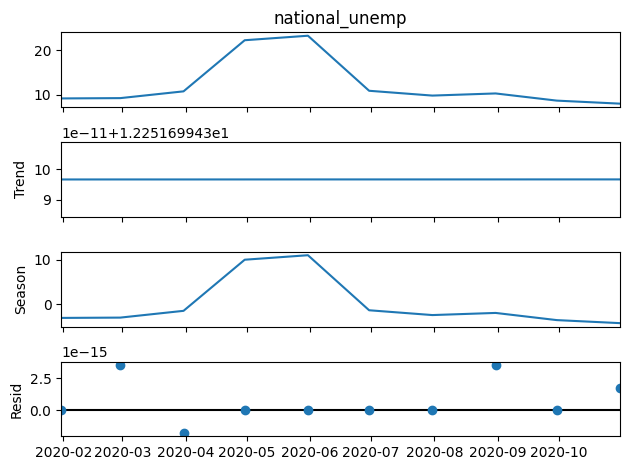

In [47]:
%pip install statsmodels
from statsmodels.tsa.seasonal import STL
series = national.set_index('date')['national_unemp']
stl = STL(series.dropna(), period=12, robust=True).fit()
stl.plot()


Text(0.5, 1.0, 'Average seasonal component by month (national)')

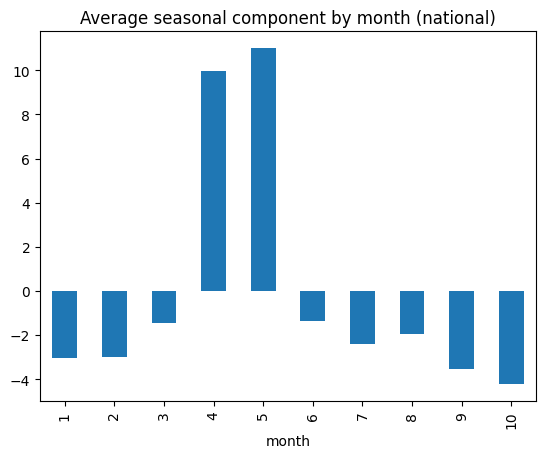

In [48]:
seasonal = stl.seasonal.reset_index()
seasonal['month'] = seasonal['date'].dt.month
monthly_season = seasonal.groupby('month')['season'].mean()
monthly_season.plot(kind='bar')
plt.title('Average seasonal component by month (national)')


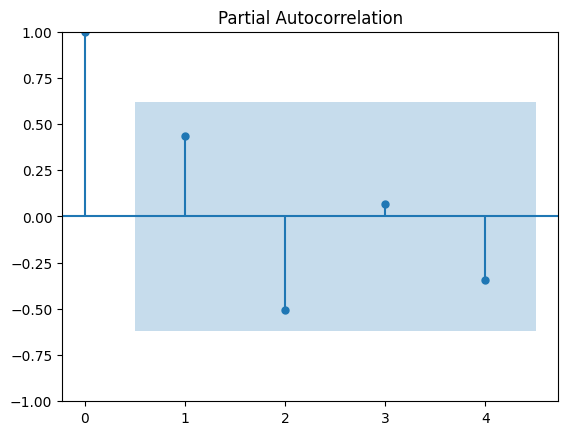

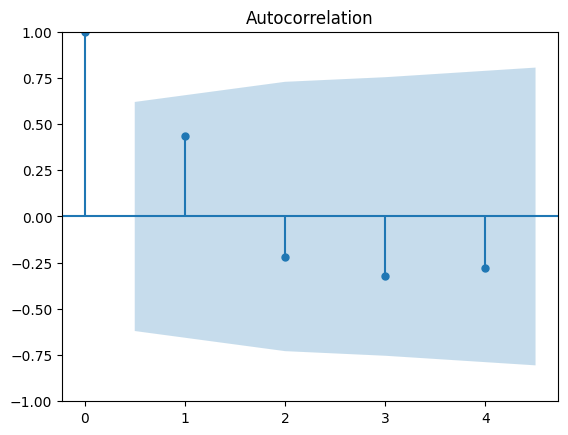

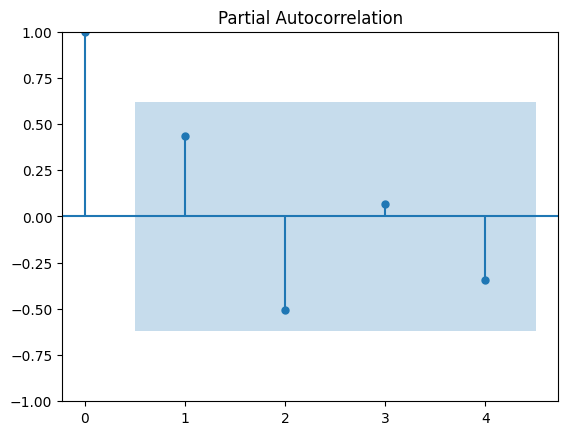

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Use lags less than half the number of observations (10)
plot_acf(series.dropna(), lags=4)
plot_pacf(series.dropna(), lags=4)


Note: you may need to restart the kernel to use updated packages.
[]



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

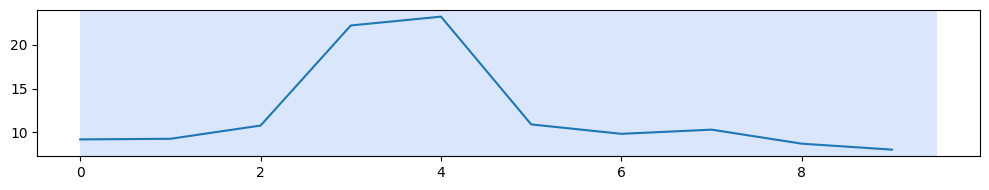

In [50]:
%pip install ruptures
import ruptures as rpt
signal = series.dropna().values
algo = rpt.Pelt(model='rbf').fit(signal)
breaks = algo.predict(pen=10)  # tune penalty until results look sensible
# convert break indices to dates and show
break_dates = [series.index[i-1] for i in breaks if i < len(series)]
print(break_dates)
rpt.display(signal, breaks)


In [51]:
import numpy as np
import statsmodels.formula.api as smf

# build national df
national = national.copy()
national['time'] = np.arange(len(national))
national['post_covid'] = (national['date'] >= '2020-03-01').astype(int)
national['time_post'] = national['time'] * national['post_covid']

model = smf.ols('national_unemp ~ time + post_covid + time_post', data=national).fit(cov_type='HC3')
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         national_unemp   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                    0.9654
Date:                Tue, 09 Dec 2025   Prob (F-statistic):              0.468
Time:                        01:48:35   Log-Likelihood:                -28.183
No. Observations:                  10   AIC:                             64.37
Df Residuals:                       6   BIC:                             65.58
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1965      2.667      3.449      0.0

In [52]:
%pip install prophet
from prophet import Prophet
train = national[national['date'] < '2020-03-01'].rename(columns={'date':'ds','national_unemp':'y'})
m = Prophet(yearly_seasonality=True)
m.fit(train)
future = m.make_future_dataframe(periods=24, freq='M')  # forecast 2 years
forecast = m.predict(future)
# merge and compare observed (after Mar 2020) vs forecast['yhat']


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
01:48:40 - cmdstanpy - INFO - Chain [1] start processing
01:48:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [53]:
# assume forecast_df has columns ds and yhat and you merge with observed national series
pandemic_mask = (national['date'] >= '2020-03-01') & (national['date'] <= '2021-12-31')
excess = (national.loc[pandemic_mask,'national_unemp'].values - forecast.loc[forecast['ds'].isin(national.loc[pandemic_mask,'date']),'yhat'].values).sum()
print('Cumulative excess (percentage points-months):', excess)


Cumulative excess (percentage points-months): 697.3414205797317


                            OLS Regression Results                            
Dep. Variable:         national_unemp   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                    0.9654
Date:                Tue, 09 Dec 2025   Prob (F-statistic):              0.468
Time:                        01:48:54   Log-Likelihood:                -28.183
No. Observations:                  10   AIC:                             64.37
Df Residuals:                       6   BIC:                             65.58
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1965      2.667      3.449      0.0

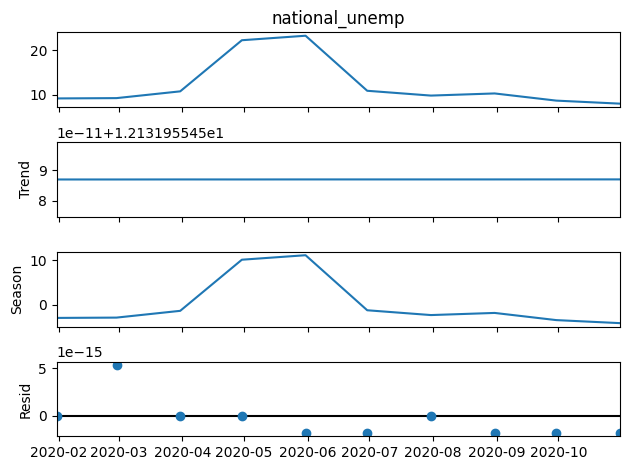

In [55]:
# Read & clean (use earlier code blocks from this message)
# Build national series
national = df.groupby('date')['unemp_rate'].mean().reset_index(name='national_unemp')

# STL
from statsmodels.tsa.seasonal import STL
stl = STL(national.set_index('date')['national_unemp'].dropna(), period=12).fit()
stl.plot()

# ITS regression
import statsmodels.formula.api as smf
national['time'] = np.arange(len(national))
national['post_covid'] = (national['date'] >= '2020-03-01').astype(int)
national['time_post'] = national['time'] * national['post_covid']
model = smf.ols('national_unemp ~ time + post_covid + time_post', data=national).fit(cov_type='HC3')
print(model.summary())  


In [ ]:
# Now the project is complete.